<a href="https://colab.research.google.com/github/oliviasteeed/Computer-Vision-Project/blob/main/computervision_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip3 install ultralytics
import ultralytics
ultralytics.checks()

import cv2
import matplotlib.pyplot as plt
import random as random
import os

Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
Setup complete ✅ (4 CPUs, 8.0 GB RAM, 303.3/894.1 GB disk)


In [ ]:
# more train with coco text dataset??
convert_coco(
    labels_dir="../coco/annotations/",
    save_dir="coco_converted/",
    use_segments=False,
    use_keypoints=False,
    cls91to80=True,
    lvis=False,
)



In [35]:
from ultralytics import YOLO

# make new model to train and load in weights from existing YOLO detection model
model = YOLO("yolov8n.yaml").load("yolov8n.pt")

# datasets
# https://universe.roboflow.com/yolo-2uwb2/text-detection-jqlql
# https://universe.roboflow.com/yolov5-train/yolo-find-text
# https://universe.roboflow.com/akshithak-0pa4q/text-detection-qj5wx
# https://bgshih.github.io/cocotext/#h2-download

# Train the model with text object detection data
results = model.train(data="/Users/oliviasteed/Desktop/iat 360/CV_Data/textdetection/data.yaml", epochs=3, imgsz=416)

Transferred 355/355 items from pretrained weights
New https://pypi.org/project/ultralytics/8.3.23 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/Users/oliviasteed/Desktop/iat 360/CV_Data/textdetection/data.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=yolov8n.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augme

train: Scanning /Users/oliviasteed/Desktop/iat 360/CV_Data/textdetection/train/l


train: New cache created: /Users/oliviasteed/Desktop/iat 360/CV_Data/textdetection/train/labels.cache


val: Scanning /Users/oliviasteed/Desktop/iat 360/CV_Data/textdetection/valid/lab


val: New cache created: /Users/oliviasteed/Desktop/iat 360/CV_Data/textdetection/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G      1.612      2.496      1.582         18        416: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         80         93     0.0344      0.753      0.369      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3         0G      1.456      1.838      1.441         27        416: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         80         93      0.751      0.455      0.651      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3         0G      1.396      1.634      1.374         14        416: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         80         93      0.718      0.656      0.697      0.415



3 epochs completed in 0.111 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         80         93      0.721      0.656      0.697      0.416
Speed: 3.5ms preprocess, 106.7ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train


In [36]:
metrics = model.val()
# print(metrics)

WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /Users/oliviasteed/Desktop/iat 360/CV_Data/textdetection/valid/lab
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         80         93      0.721      0.656      0.697      0.416
Speed: 4.8ms preprocess, 129.9ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train2


In [38]:
# test model with train data (should work)
model("/Users/oliviasteed/Desktop/iat 360/CV_Data/textdetection/train/images/100_jpg.rf.072e86458094f004ab381eb018f48ea0.jpg", save=True)
# does not work


image 1/1 /Users/oliviasteed/Desktop/iat 360/CV_Data/textdetection/train/images/100_jpg.rf.072e86458094f004ab381eb018f48ea0.jpg: 416x416 (no detections), 618.1ms
Speed: 31.0ms preprocess, 618.1ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/detect/train4


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: '0'}
 obb: None
 orig_img: array([[[ 13,  13,  13],
         [  9,   9,   9],
         [  7,   7,   7],
         ...,
         [ 30,  32,  32],
         [ 23,  23,  23],
         [ 21,  21,  21]],
 
        [[ 14,  14,  14],
         [  9,   9,   9],
         [  7,   7,   7],
         ...,
         [ 30,  32,  32],
         [ 20,  20,  20],
         [ 16,  16,  16]],
 
        [[ 21,  21,  21],
         [ 16,  16,  16],
         [ 12,  12,  12],
         ...,
         [ 28,  30,  30],
         [ 21,  21,  21],
         [ 18,  18,  18]],
 
        ...,
 
        [[ 44,  46,  46],
         [ 49,  51,  51],
         [ 61,  61,  61],
         ...,
         [189, 190, 200],
         [181, 182, 192],
         [159, 160, 170]],
 
        [[ 46,  48,  48],
         [ 45,  47,  47],
         [ 50,  50,  50],
         ...,
         [179, 180, 190

In [31]:
# results =model("/Users/oliviasteed/Desktop/iat 360/cv/textdetection/train/images/100_jpg.rf.072e86458094f004ab381eb018f48ea0.jpg", save=True)

# showing label - to check if it is labeled right (it is)
%matplotlib inline
from PIL import Image

def draw_yolo_bbox(image_path, label_path):
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape

    # Read label file
    with open(label_path, 'r') as file:
        bboxes = file.readlines()

    # Draw each bbox
    for bbox in bboxes:
        class_id, x_center, y_center, bbox_width, bbox_height = [float(x) for x in bbox.split()]

        # Convert YOLO bbox format to rectangle coordinates
        x1 = int((x_center - bbox_width / 2) * width)
        y1 = int((y_center - bbox_height / 2) * height)
        x2 = int((x_center + bbox_width / 2) * width)
        y2 = int((y_center + bbox_height / 2) * height)

        # Draw rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        # Put label (class_id) near the bbox
        # label = class_labels[int(class_id)]
        label = "text"
        cv2.putText(image, label, (x1, y1+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
    # Display image
    plt.imshow(image)
    # Image.open(image)
    plt.axis('off')
    plt.savefig('test.jpg')
    return

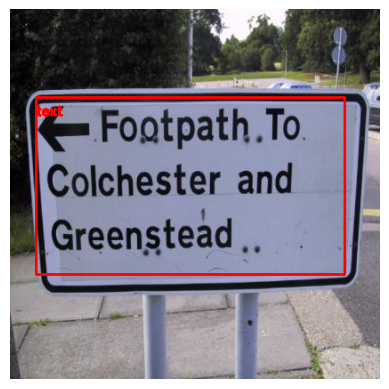

In [39]:
draw_yolo_bbox("/Users/oliviasteed/Desktop/iat 360/cv/textdetection/train/images/100_jpg.rf.072e86458094f004ab381eb018f48ea0.jpg", "/Users/oliviasteed/Desktop/iat 360/cv/textdetection/train/labels/100_jpg.rf.072e86458094f004ab381eb018f48ea0.txt")

In [41]:
# train with more data

# load in best previous model (test/weights/best.pt)
model1 = YOLO('/Users/oliviasteed/runs/detect/train/weights/best.pt')

# Train the model with text object detection data
results1 = model1.train(data="/Users/oliviasteed/Desktop/iat 360/CV_Data/Yolo find text v2/data.yaml", epochs=3, imgsz=640)

New https://pypi.org/project/ultralytics/8.3.23 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
engine/trainer: task=detect, mode=train, model=/Users/oliviasteed/runs/detect/train/weights/best.pt, data=/Users/oliviasteed/Desktop/iat 360/CV_Data/Yolo find text v2/data.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, a

train: Scanning /Users/oliviasteed/Desktop/iat 360/CV_Data/Yolo find text v2/tra

train: New cache created: /Users/oliviasteed/Desktop/iat 360/CV_Data/Yolo find text v2/train/labels.cache



val: Scanning /Users/oliviasteed/Desktop/iat 360/CV_Data/Yolo find text v2/valid

val: New cache created: /Users/oliviasteed/Desktop/iat 360/CV_Data/Yolo find text v2/valid/labels.cache


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train5
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G       2.28      2.558      1.863         55        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         61        241      0.943      0.411      0.666      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3         0G      1.321      1.449      1.115         54        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         61        241      0.969      0.904      0.958      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3         0G      1.167      1.161      1.044         44        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         61        241      0.968      0.954       0.99      0.595



3 epochs completed in 0.189 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.2MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         61        241      0.969      0.904      0.958      0.604
Speed: 5.5ms preprocess, 227.2ms inference, 0.0ms loss, 12.1ms postprocess per image
Results saved to runs/detect/train5


In [42]:
# validating model with more data
model1.val()

Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /Users/oliviasteed/Desktop/iat 360/CV_Data/Yolo find text v2/valid
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         61        241      0.969      0.904      0.958      0.604
Speed: 10.6ms preprocess, 271.0ms inference, 0.0ms loss, 11.1ms postprocess per image
Results saved to runs/detect/train52


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x125d93650>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048,    

In [43]:
# validate on train data
model1("/Users/oliviasteed/Desktop/iat 360/CV_Data/textdetection/train/images/100_jpg.rf.072e86458094f004ab381eb018f48ea0.jpg", save=True)
# does not work


image 1/1 /Users/oliviasteed/Desktop/iat 360/CV_Data/textdetection/train/images/100_jpg.rf.072e86458094f004ab381eb018f48ea0.jpg: 640x640 (no detections), 313.3ms
Speed: 7.0ms preprocess, 313.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train53


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Text'}
 obb: None
 orig_img: array([[[ 13,  13,  13],
         [  9,   9,   9],
         [  7,   7,   7],
         ...,
         [ 30,  32,  32],
         [ 23,  23,  23],
         [ 21,  21,  21]],
 
        [[ 14,  14,  14],
         [  9,   9,   9],
         [  7,   7,   7],
         ...,
         [ 30,  32,  32],
         [ 20,  20,  20],
         [ 16,  16,  16]],
 
        [[ 21,  21,  21],
         [ 16,  16,  16],
         [ 12,  12,  12],
         ...,
         [ 28,  30,  30],
         [ 21,  21,  21],
         [ 18,  18,  18]],
 
        ...,
 
        [[ 44,  46,  46],
         [ 49,  51,  51],
         [ 61,  61,  61],
         ...,
         [189, 190, 200],
         [181, 182, 192],
         [159, 160, 170]],
 
        [[ 46,  48,  48],
         [ 45,  47,  47],
         [ 50,  50,  50],
         ...,
         [179, 180, 

In [44]:
# train with more data

# load in best previous model (test/weights/best.pt)
model2 = YOLO('/Users/oliviasteed/runs/detect/train5/weights/best.pt')

# Train the model with text object detection data
results2 = model2.train(data="/Users/oliviasteed/Desktop/iat 360/CV_Data/Text_detection_box.v1/data.yaml", epochs=5, imgsz=416)

New https://pypi.org/project/ultralytics/8.3.23 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
engine/trainer: task=detect, mode=train, model=/Users/oliviasteed/runs/detect/train5/weights/best.pt, data=/Users/oliviasteed/Desktop/iat 360/CV_Data/Text_detection_box.v1/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=Fal

train: Scanning /Users/oliviasteed/Desktop/iat 360/CV_Data/Text_detection_box.v1

train: New cache created: /Users/oliviasteed/Desktop/iat 360/CV_Data/Text_detection_box.v1/train/labels.cache



val: Scanning /Users/oliviasteed/Desktop/iat 360/CV_Data/Text_detection_box.v1/v

val: New cache created: /Users/oliviasteed/Desktop/iat 360/CV_Data/Text_detection_box.v1/valid/labels.cache


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs/detect/train6
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.361      1.504       1.21          3        416: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        106        318      0.672       0.89      0.836      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      1.101     0.8437      1.029         10        416: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        106        318      0.788       0.78      0.902      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      1.072     0.7524     0.9971          3        416: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        106        318      0.997      0.997      0.992       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      1.002     0.7035     0.9971          8        416: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        106        318      0.997      0.997      0.995      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G     0.9956     0.6741     0.9934          2        416: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        106        318      0.996      0.997      0.995      0.727



5 epochs completed in 0.234 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 6.2MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        106        318      0.996      0.997      0.995      0.727
Speed: 3.1ms preprocess, 112.4ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train6


In [45]:
# validating model with more data
model2.val()

Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /Users/oliviasteed/Desktop/iat 360/CV_Data/Text_detection_box.v1/v
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        106        318      0.996      0.997      0.995      0.727
Speed: 3.3ms preprocess, 116.5ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to runs/detect/train62


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x1324c9280>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048,    


image 1/1 /Users/oliviasteed/Desktop/iat 360/CV_Data/Text_detection_box.v1/train/images/Ar_16_An_16_TNR_16_Image14_jpg.rf.0db41e1c1897b2d8cc6e07640ae17911.jpg: 416x416 3 Texts, 149.3ms
Speed: 1.5ms preprocess, 149.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/detect/train65


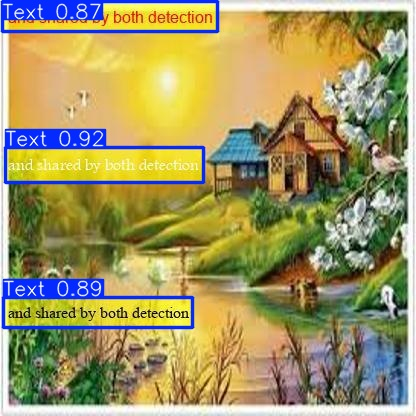

In [48]:
# validate on train data

%matplotlib inline
from PIL import Image

model2("/Users/oliviasteed/Desktop/iat 360/CV_Data/Text_detection_box.v1/train/images/Ar_16_An_16_TNR_16_Image14_jpg.rf.0db41e1c1897b2d8cc6e07640ae17911.jpg", save=True)
# detects text!!!!!!

Image.open('/Users/oliviasteed/runs/detect/train65/Ar_16_An_16_TNR_16_Image14_jpg.rf.0db41e1c1897b2d8cc6e07640ae17911.jpg')


image 1/1 /Users/oliviasteed/Desktop/iat 360/CV_Data/textdetection/test/images/121_jpg.rf.47a836a556ba2bbe6cb8c97f7590e8eb.jpg: 416x416 2 Texts, 145.2ms
Speed: 3.4ms preprocess, 145.2ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/detect/train66


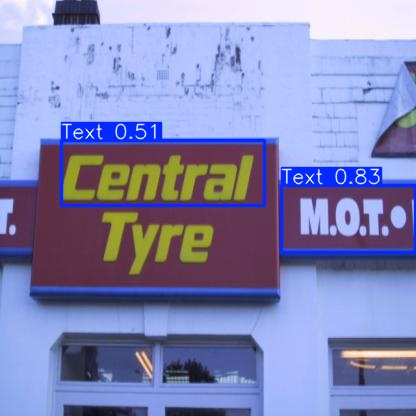

In [49]:
# test again
model2("/Users/oliviasteed/Desktop/iat 360/CV_Data/textdetection/test/images/121_jpg.rf.47a836a556ba2bbe6cb8c97f7590e8eb.jpg", save=True)

Image.open('/Users/oliviasteed/runs/detect/train66/121_jpg.rf.47a836a556ba2bbe6cb8c97f7590e8eb.jpg')


image 1/1 /Users/oliviasteed/Desktop/iat 360/CV_Data/Yolo find text v2/test/images/15_png.rf.386b8c69a26918f16c134667e19b7414.jpg: 416x416 (no detections), 149.1ms
Speed: 2.4ms preprocess, 149.1ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/detect/train67


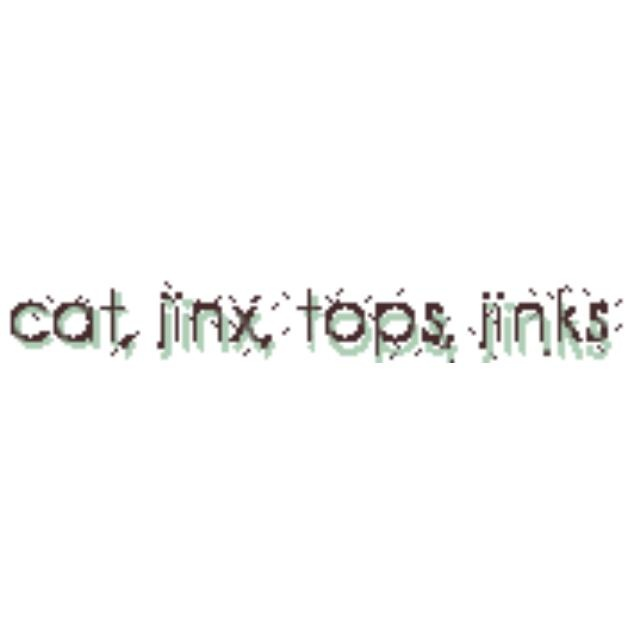

In [50]:
# test again
model2("/Users/oliviasteed/Desktop/iat 360/CV_Data/Yolo find text v2/test/images/15_png.rf.386b8c69a26918f16c134667e19b7414.jpg", save=True)

Image.open('/Users/oliviasteed/runs/detect/train67/15_png.rf.386b8c69a26918f16c134667e19b7414.jpg')

In [ ]:
# train on more
# https://universe.roboflow.com/donatas-puidokas/text-objects/dataset/1

# load in best previous model (test/weights/best.pt)
model3 = YOLO('/Users/oliviasteed/runs/detect/train6/weights/best.pt')

# Train the model with text object detection data
results3 = model3.train(data="/Users/oliviasteed/Desktop/iat 360/CV_Data/Text objects.v1i.yolov8/data.yaml", epochs=5, imgsz=640)


New https://pypi.org/project/ultralytics/8.3.23 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
engine/trainer: task=detect, mode=train, model=/Users/oliviasteed/runs/detect/train6/weights/best.pt, data=/Users/oliviasteed/Desktop/iat 360/CV_Data/Text objects.v1i.yolov8/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=F

train: Scanning /Users/oliviasteed/Desktop/iat 360/CV_Data/Text objects.v1i.yolo


train: New cache created: /Users/oliviasteed/Desktop/iat 360/CV_Data/Text objects.v1i.yolov8/train/labels.cache


val: Scanning /Users/oliviasteed/Desktop/iat 360/CV_Data/Text objects.v1i.yolov8

val: New cache created: /Users/oliviasteed/Desktop/iat 360/CV_Data/Text objects.v1i.yolov8/valid/labels.cache


Plotting labels to runs/detect/train7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train7
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.125      2.031      1.303         45        640:  